In [2]:
from core.utils import * 
from core.evaluator import predictor, build_graph
from core.datasetclass import LinearElasticityDataset
from core.model_graphnet import EncodeProcessDecode
from core.fem_solver import *
from tqdm import tqdm
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from dolfinx import fem, io, default_scalar_type, mesh

In [3]:
torch.manual_seed(42) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = LinearElasticityDataset(data_dir = "/home/narupanta/ADDMM/surrogate_model/dataset")
print("number of trajectories: ", len(dataset))
_, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle = False)

number of trajectories:  900


In [4]:
model_path = "/home/narupanta/ADDMM/surrogate_model/output/2025-01-31T00h02m37s/model_checkpoint"
model = EncodeProcessDecode(node_feat_size=4,
                            edge_feat_size= 1,
                            output_size=2,
                            latent_size=128,
                            message_passing_steps=15)
model.load_model(model_path)
model.to(device)

EncodeProcessDecode(
  (_output_normalizer): Normalizer()
  (_node_features_normalizer): Normalizer()
  (_edge_features_normalizer): Normalizer()
  (node_encode_net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (edge_encode_net): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (node_decode_net): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (message_pass): GraphNetBlock()
)

In [5]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    loop = tqdm(enumerate(test_loader), total = len(test_loader), leave = False)
    for idx_traj, batch in loop:
        batch.to(device)
        outputs = model(batch)
        loss = model.loss_function(outputs, batch.y)
        test_loss += loss.item()
        loop.set_description(f"Trajectory {idx_traj + 1}/{len(test_loader)}")
        loop.set_postfix({"Test MSE Loss": f"{loss.item():.4f}"})
    print(f"Average Test MSE Loss: {test_loss:.4f}")

Average Test MSE Loss: 0.2625


Sample some test sample

In [6]:
test_iter = iter(test_loader)
test_sample = next(test_iter)
test_sample = test_sample.to(device)
_, test_predict = predictor(model, test_sample)

In [7]:
def plot_result_compare_FEM(mesh_pos, triangles, predictions, fem_result) :
    # Get node coordinates
    nodes = mesh_pos  # Extract the x, y coordinates (for 2D)
    predictions_plot = predictions
    fem_result = fem_result
    plotdata = {"predicted displacement" : predictions_plot, "FEM displacement" : fem_result, "error field" : np.abs(predictions_plot - fem_result)}
    # Get connectivity for triangular elements
    # normalized_mat_params = data.material_params[0].cpu() 
    # material_parameters = normalized_mat_params * matstd + matmean
    # Plotting
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], triangles)

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(24, 6))  # 2 row, 3 columns

    # First subplot
    for key, v in plotdata.items() :
        for j in range(2) :
            i = list(plotdata.keys()).index(key)
            if key != "error field" :
                im = axes[j][i].tripcolor(triangulation, plotdata[key][:, j], shading='flat', cmap='viridis')
            else :
                im = axes[j][i].tripcolor(triangulation, plotdata[key][:, j], shading='flat', cmap='viridis')
            axes[j][i].triplot(triangulation, color='black', linewidth=0.5)
            if j == 0 :
                axes[j][i].set_title(f"{key} X")
            else :
                axes[j][i].set_title(f"{key} Y")
            axes[j][i].set_xlabel("X-coordinate")
            axes[j][i].set_ylabel("Y-coordinate")
            fig.colorbar(im, ax=axes[j][i], orientation='vertical', label="Nodal Value")
    # fig.suptitle(material_parameters.detach().numpy(), fontsize=16)
    plt.tight_layout()
    plt.show()

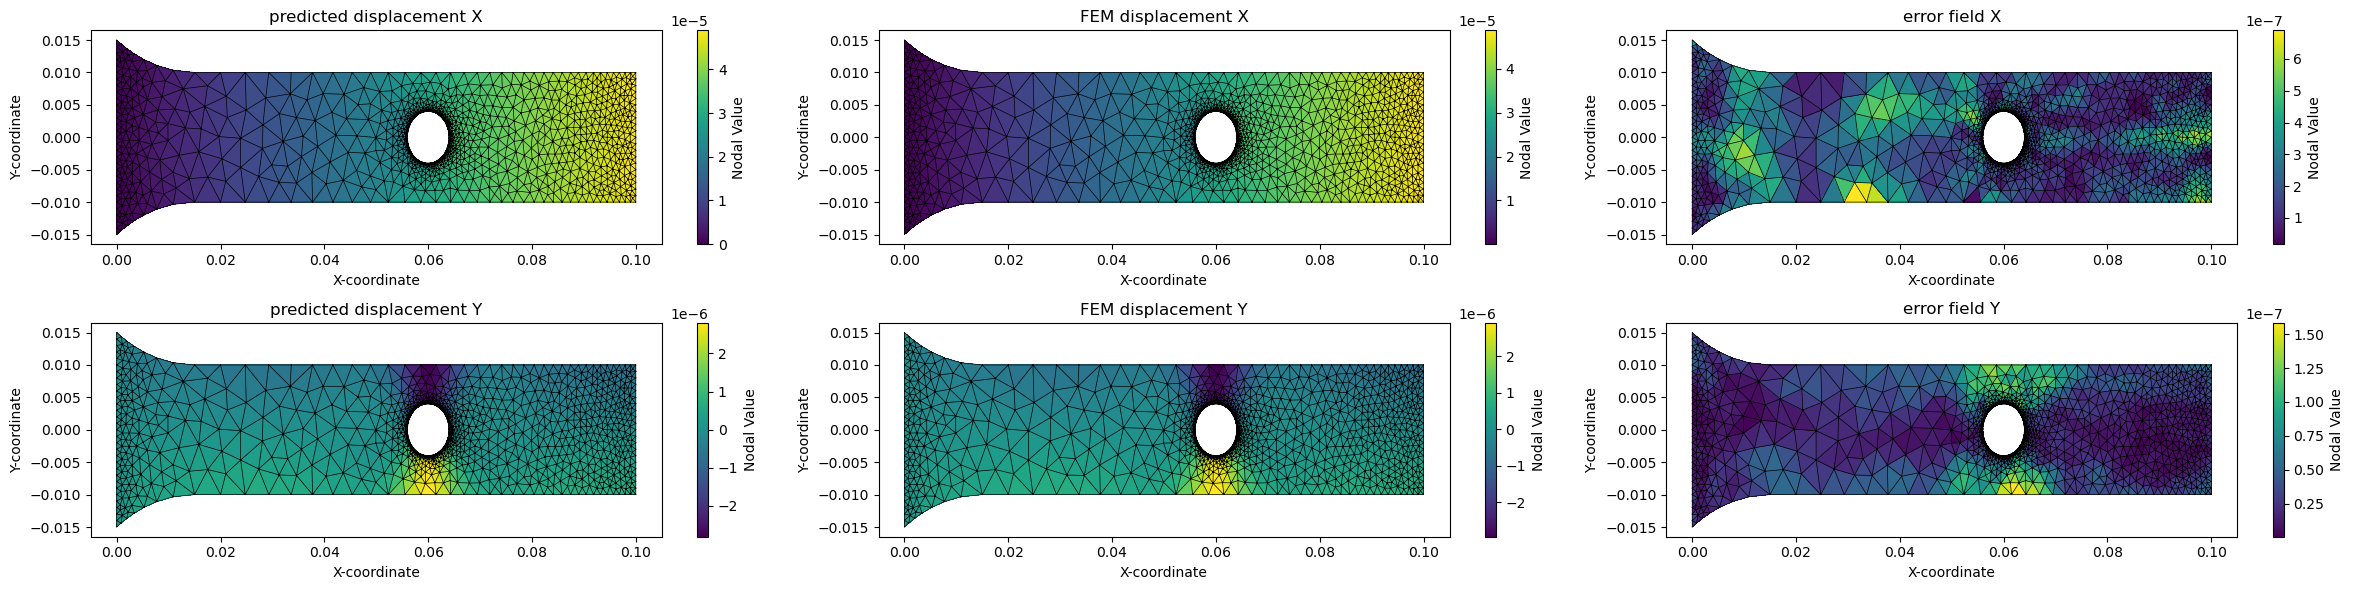

In [8]:
mesh_pos = test_sample.x[:, :2].cpu().detach().numpy()
traiangles = test_sample.triangles.cpu().detach().numpy()
predictions = test_predict.cpu().detach().numpy()
ground_truth = test_sample.y.cpu().detach().numpy()
plot_result_compare_FEM(mesh_pos, traiangles, predictions, ground_truth)

Try inputting G = 7.224e+10 Pa, K = 9.169e+10 Pa to see if the result matches with FEM.

In [9]:
mesh_file = "/home/narupanta/ADDMM/surrogate_model/rectangle_with_hole.msh"
msh_data = io.gmshio.read_from_msh(mesh_file, MPI.COMM_WORLD, 0)
mesh_pos, node_connectivity = get_mesh(msh_data)
G = 72.24e9
K = 91.69e9

Info    : Reading '/home/narupanta/ADDMM/surrogate_model/rectangle_with_hole.msh'...
Info    : 30 entities
Info    : 1117 nodes
Info    : 2048 elements
Info    : Done reading '/home/narupanta/ADDMM/surrogate_model/rectangle_with_hole.msh'


In [10]:
_, _, displacement = solve_fem(msh_data, G, K)

In [11]:
input_graph = build_graph(mesh_pos = torch.tensor(mesh_pos, dtype = torch.float32), node_connectivity = torch.tensor(node_connectivity, dtype = torch.int), material_params = torch.tensor([G, K], dtype = torch.float))
input_graph = input_graph.to(device)
_, predicted_displacement = predictor(model, input_graph)
predicted_displacement = predicted_displacement.detach().cpu().numpy()

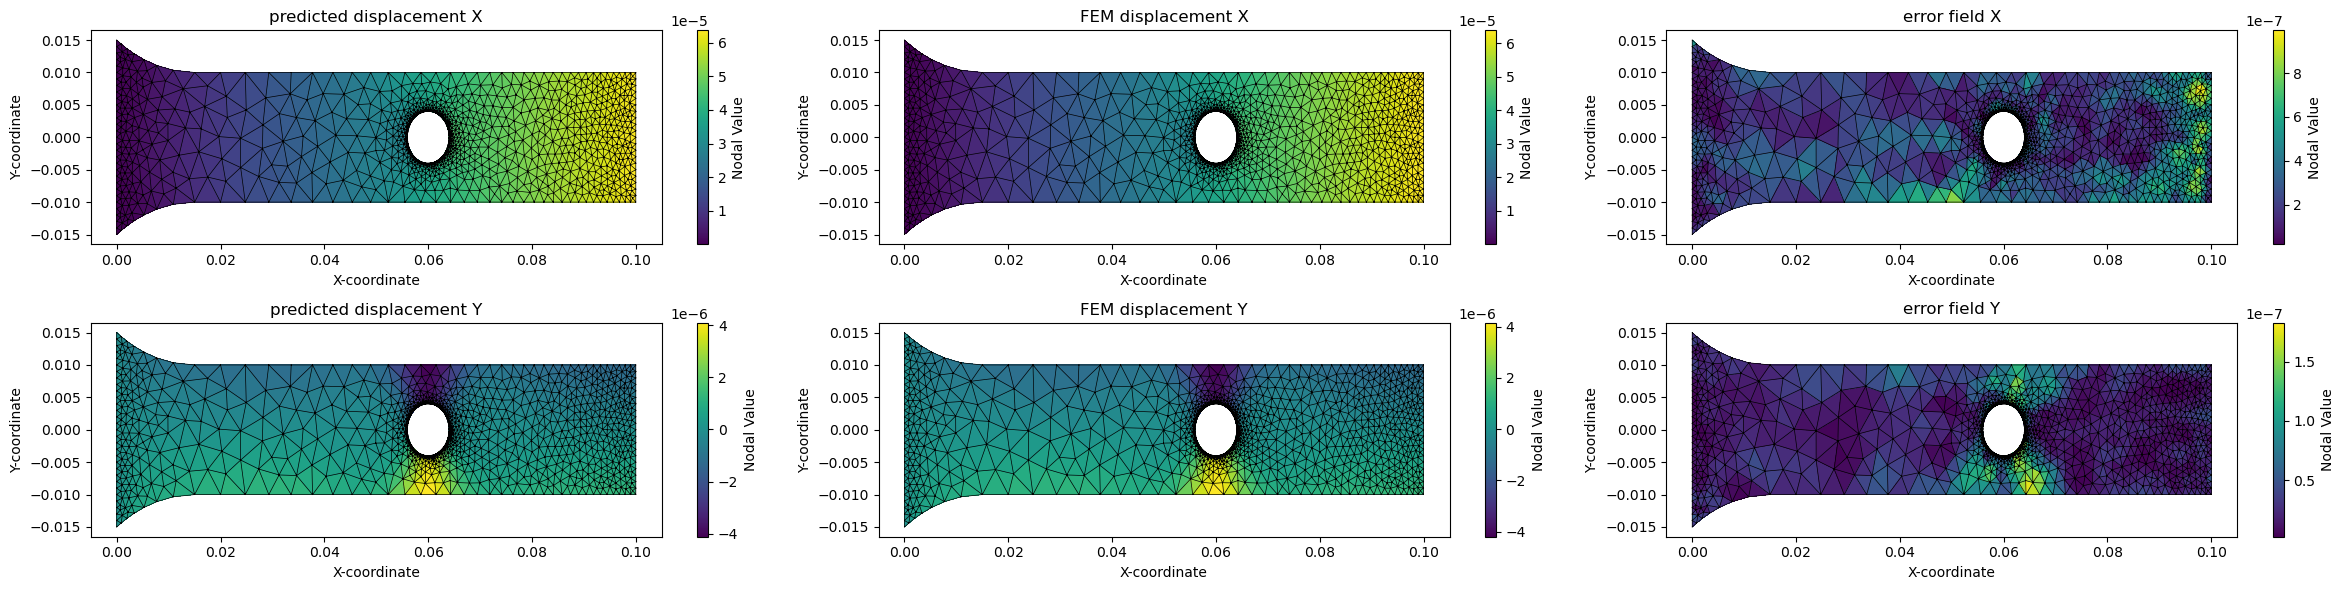

In [12]:
plot_result_compare_FEM(mesh_pos, node_connectivity, predicted_displacement, displacement)

Let test the model to perform material parameters identification from the FEM result with reference G and K above. 

In [13]:
from scipy.optimize import minimize

In [15]:
def callback(xk):
    print(f"Current solution: {xk}")

class OptimizationHistory:
    def __init__(self):
        self.history = []

    def __call__(self, xk):
        # Save current parameter values
        self.history.append(xk.copy())
        
def mse_loss(ground_truth, predictor, model, msh_data, BETA) :
    G, K = BETA
    mesh_pos, node_connectivity = get_mesh(msh_data)
    input_graph = build_graph(mesh_pos = torch.tensor(mesh_pos, dtype = torch.float32), node_connectivity = torch.tensor(node_connectivity, dtype = torch.int), material_params = torch.tensor([G, K], dtype = torch.float))
    input_graph = input_graph.to(device)
    _, predictions = predictor(model, input_graph)
    cpu_predictions = predictions.detach().cpu().numpy()
    error = np.sum((cpu_predictions - ground_truth)**2, axis = 1)
    mse = np.mean(error, axis = 0)
    print(BETA, mse) 
    return mse
history = OptimizationHistory()
beta = [1e+9, 1e+9]
model = model.to(device)
result = minimize(
    fun=lambda x: mse_loss(displacement, predictor, model, msh_data, x),
    x0=beta,
    method='Nelder-Mead',
    options={'gtol': 1e-7, 'maxiter': 1000},
    callback=history
)

[1.e+09 1.e+09] 8.708238001346427e-10
[1.05e+09 1.00e+09] 8.703230857724724e-10
[1.00e+09 1.05e+09] 8.704721027722896e-10
[1.05e+09 1.05e+09] 8.69969667110214e-10
[1.075e+09 1.075e+09] 8.696149607986378e-10
[1.125e+09 1.025e+09] 8.691819154702544e-10
[1.1875e+09 1.0125e+09] 8.686083459180945e-10
[1.2125e+09 1.0875e+09] 8.681820752197872e-10
[1.29375e+09 1.13125e+09] 8.673966517843645e-10
[1.40625e+09 1.06875e+09] 8.665291357565448e-10
[1.571875e+09 1.065625e+09] 8.651929599114912e-10
[1.678125e+09 1.184375e+09] 8.641185663111656e-10
[1.9234375e+09 1.2703125e+09] 8.62082172485756e-10
[2.2015625e+09 1.2046875e+09] 8.600069919576887e-10
[2.65546875e+09 1.24140625e+09] 8.56505115722353e-10
[3.00703125e+09 1.44609375e+09] 8.535219276553909e-10
[3.72460938e+09 1.63632812e+09] 8.478635797756636e-10
[4.45664062e+09 1.60742188e+09] 8.423642563132273e-10
[5.72324219e+09 1.77597656e+09] 8.326517455715325e-10
[6.79238281e+09 2.17089844e+09] 8.241323077415772e-10
[8.86083984e+09 2.63564453e+09] 8.0

In [14]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 7.901381782776153e-14
             x: [ 6.992e+10  9.689e+10]
           nit: 102
          nfev: 280
 final_simplex: (array([[ 6.992e+10,  9.689e+10],
                       [ 6.992e+10,  9.689e+10],
                       [ 6.992e+10,  9.689e+10]]), array([ 7.901e-14,  7.994e-14,  7.995e-14]))

Let use the model to perform material parameters identification from the experimental data (deformation) from DIC. 
Firstly, we only have specific domain the displacement data, which is smaller than what the fem and model result. 
- We then use observer operator to crop the 

In [19]:
import pandas as pd

Prepare the experimental data

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
from scipy.interpolate import griddata
raw = True
if raw:
    df = pd.read_csv(r"/mnt/c/Users/bankp/OneDrive/Desktop/ADDMM/dataset/20231116_displacements_raw.csv")
else :
    df = pd.read_csv(r"/mnt/c/Users/bankp/OneDrive/Desktop/ADDMM/dataset/20231116_displacements_interpolated.csv")
def remove_outliers_zscore(df, columns, threshold=3):
    """
    Removes outliers from specified columns in a DataFrame using the Z-score method.

    Parameters:
    - df: DataFrame from which to remove outliers.
    - columns: List of column names to check for outliers.
    - threshold: Z-score threshold to determine outliers (default is 3).

    Returns:
    - Cleaned DataFrame with outliers removed.
    """
    cleaned_df = df.copy()

    for column in columns:
        # Calculate the mean and standard deviation
        mean = cleaned_df[column].mean()
        std = cleaned_df[column].std()

        # Calculate the Z-score for each value in the column
        z_scores = (cleaned_df[column] - mean) / std

        # Filter out outliers based on the Z-score threshold
        cleaned_df = cleaned_df[(np.abs(z_scores) <= threshold)]

    return cleaned_df
def fill_na_with_neighbors(flattened_image, shape):
    rows, cols = shape
    for i in range(1, len(flattened_image) - 1):
        if np.isnan(flattened_image[i]):
            # Get the row and column indices of the pixel in the 2D image
            row = i // cols
            col = i % cols

            # Get the neighbors (left, right, top, bottom) in the flattened array
            neighbors = []
            if col > 0:  # Left neighbor
                neighbors.append(flattened_image[i - 1])
            if col < cols - 1:  # Right neighbor
                neighbors.append(flattened_image[i + 1])
            if row > 0:  # Top neighbor
                neighbors.append(flattened_image[i - cols])
            if row < rows - 1:  # Bottom neighbor
                neighbors.append(flattened_image[i + cols])

            # Remove NaN values from the neighbors list
            neighbors = [val for val in neighbors if not np.isnan(val)]

            # If there are valid neighbors, replace the NaN with the mean
            if neighbors:
                flattened_image[i] = np.mean(neighbors)
    
    return flattened_image

def mask_hole(X, Y) :
    center_x, center_y = 40e-3, 10e-3
    radius = 4e-3

    # Calculate the distance of each point from the center of the circle
    distance_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)

    # Create a mask: True for points outside the circle, False for points inside
    return distance_from_center >= radius
def get_displacement_at_point(df, x, y, isClearOutlier):
    """
    Interpolates displacement data at a specified (x, y) point.

    Parameters:
    - df: DataFrame with columns ['x', 'y', 'displacement_x', 'displacement_y'].
    - x: float, x-coordinate of the point to interpolate.
    - y: float, y-coordinate of the point to interpolate.
    - method: Interpolation method (default is 'linear').

    Returns:
    - interpolated_displacement_x: Interpolated displacement_x value at the specified point.
    - interpolated_displacement_y: Interpolated displacement_y value at the specified point.
    """
    if isClearOutlier :
        df = remove_outliers_zscore(df, ['x-displacement [mm]', "y-displacement [mm]"], 3)
    # Extract points and displacement values from the DataFrame
    points = df[['x-coordinate [mm]', 'y-coordinate [mm]']].values/1000
    displacement_x = df['x-displacement [mm]'].values/1000
    displacement_y = df['y-displacement [mm]'].values/1000
    # Create interpolators for displacement_x and displacement_y
    interp_x = fill_na_with_neighbors(griddata(points, displacement_x, (x, y), method='linear'), points.shape)
    interp_y = fill_na_with_neighbors(griddata(points, displacement_y, (x, y), method='linear'), points.shape)
    return interp_x, interp_y
X, Y = node_coordinates[:, 0], node_coordinates[:, 1]
mask = mask_hole(X, Y)
Z_x = get_displacement_at_point(df, X, Y, True)[0]
Z_y = get_displacement_at_point(df, X, Y, True)[1]
X_train, Y_train =  np.where(mask, X, np.nan), np.where(mask, Y, np.nan)
Z_x_train = np.where(mask, Z_x, np.nan)
Z_y_train = np.where(mask, Z_y, np.nan)
# # Plotting the mesh
fig, ax = plt.subplots(2, 1, figsize=(24, 12))
print(np.max(Z_x))
# # # Subplot for displacement_x
contour_x = ax[0].tricontourf(X, Y , Z_x , levels=25, cmap='plasma')
cbar_x = fig.colorbar(contour_x, ax=ax[0], label='Displacement X (mm)')
ax[0].set_title('X Displacement with Hole Masked')
ax[0].set_xlabel('X Coordinate [mm]')
ax[0].set_ylabel('Y Coordinate [mm]')
ax[0].grid(True)

# Subplot for Y displacement
contour_y = ax[1].tricontourf(X, Y , Z_y, levels=25, cmap='viridis')
cbar_y = fig.colorbar(contour_y, ax=ax[1], label='Displacement Y (mm)')
ax[1].set_title('Y Displacement with Hole Masked')
ax[1].set_xlabel('X Coordinate [mm]')
ax[1].set_ylabel('Y Coordinate [mm]')
ax[1].grid(True)
# Display the plots
plt.show()

In [20]:
exp_data = pd.read_csv("/home/narupanta/ADDMM/parameter_identification/11257192/20231116_displacements_raw.csv")
exp_mesh = exp_data

,x-coordinate [mm],y-coordinate [mm],x-displacement [mm],y-displacement [mm]
0,-1.213225,18.682079,0.037064,-0.007307
1,-0.182101,1.200903,0.010068,0.006017
2,-0.219830,1.772009,0.004856,0.010216
3,-0.246522,2.359436,-0.003729,0.021044
4,-0.299186,4.682294,0.015228,-0.003201
...,...,...,...,...
5470,81.318982,9.771719,0.060814,-0.004457
5471,81.328273,10.372536,0.063073,0.001662
5472,81.723731,1.227252,0.062143,-0.000846
5473,81.847507,8.867827,0.058975,-0.006585


In [16]:
predicted_displacement.shape

(1117, 2)

In [18]:
input_graph.x

tensor([[ 0.0000e+00, -1.5000e-02,  7.2240e+10,  9.1690e+10],
        [ 8.4445e-04, -1.4394e-02,  7.2240e+10,  9.1690e+10],
        [ 0.0000e+00, -1.4000e-02,  7.2240e+10,  9.1690e+10],
        ...,
        [ 1.0000e-01,  1.0000e-03,  7.2240e+10,  9.1690e+10],
        [ 1.0000e-01,  3.0000e-03,  7.2240e+10,  9.1690e+10],
        [ 1.0000e-01,  2.0000e-03,  7.2240e+10,  9.1690e+10]], device='cuda:0')